# Networks - Final Project
## Superblock Placement Impact on Traffic

### by Clarice Mottet, Amber Walker, Mox Ballo

 **[Set-Up: Frank-Wolfe Algorithm](#fw)**
- Utilize source code available to implement the Frank-Wolfe algorithm in finding Nash equilibrium and social optimal flow solutions.
- https://nbviewer.org/github/PyTrans/Urban-Network-Analysis/blob/master/Trip_Assignment-Frank-Wolfe_Algorithm.ipynb

 **[Set-Up: PyTrans Class Adjustments](#pytrans)**
- Using source code available, adjust the directed graph formation code for the removal of Superblock edges.
- https://github.com/PyTrans/Urban-Network-Analysis/tree/master/pytrans/UrbanNetworkAnalysis

 **[Set-Up: Superblock Identification and Incorporation](#super)**
- Comprises Superblock identification algorithm, Superblock visualization, functions to incorporate a Superblock into a road network.

 **[Simulation: Superblock](#sim)**
- Determine baseline and conduct simulations of Superblock incorporation into road network.

 **[Analysis: Simulation Results](#analy)**
- Import simulation results and perform comparative analysis of total travel time and total cost. 

### General Overview of Findings:

* We identified 87 distinct Superblocks in the city of Barcelona.
* With only one simulation for Nash equilibrium of flow and social optimum of flow, we found PoA yielding unlikely results. Further analysis is required.

In [232]:
#libraries

import pandas as pd
import os
import numpy as np
import networkx as nx
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from scipy.misc import derivative
import time

import TransportationNetworks_CM as tncm

path_in_ = r'/home/clarice/Documents/VSCode/Term2_Networks/final_project/networks_finalproject/inputs/'
path_out_ = r'/home/clarice/Documents/VSCode/Term2_Networks/final_project/networks_finalproject/outputs/'
path_out_nash_ = r'/home/clarice/Documents/VSCode/Term2_Networks/final_project/networks_finalproject/outputs/nash_equilibrium_flow/'
path_out_social_ = r'/home/clarice/Documents/VSCode/Term2_Networks/final_project/networks_finalproject/outputs/social_optimum_flow/'

## <a id='fw'>Set-Up: Frank-Wolfe Algorithm</a>
- **Functions**:
  - BPR, line search optimization, wrapper functions for easy reference during simulations.

In [233]:
#functions: user, based on jupyter notebook

#from website to calculate latency
def BPR(t0, xa, ca, alpha, beta):
    ta = t0*(1+alpha*(xa/ca)**beta)
    return ta

#from website: method to calculate nash equilibrium (when SO = False)
def calculateZ(theta, network, SO):
    z = 0
    for linkKey, linkVal in network.items():
        t0 = linkVal['t0']
        ca = linkVal['capa']
        beta = linkVal['beta']
        alpha = linkVal['alpha']
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        
        if SO == False:
            z += integrate.quad(lambda x: BPR(t0, x, ca, alpha, beta), 0, flow+theta*(aux-flow))[0]
        elif SO == True:
            z += list(map(lambda x : x * BPR(t0, x, ca, alpha, beta), [flow+theta*(aux-flow)]))[0]
    return z

#from website: finds nash equilibrium
def lineSearch(network, SO):
    theta = minimize_scalar(lambda x: calculateZ(x, network, SO), bounds = (0,1), method = 'Bounded')
    return theta.x

In [234]:
#functions: user, based on jupyter notebook

def initialize(link_file, trip_file, od_vols, origins, od_dic, links, graph, SO):
    #set objective and open the network
    barcelonaSubset = tncm.Network(link_file, trip_file, od_vols, origins, od_dic, links, graph)

    #CM - start of initialization

    # define output variables, network and fwResult
    network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
            'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
            'auxiliary':[], 'cost':[]} for (u, v, d) in barcelonaSubset.graph.edges(data=True)}

    fwResult = {'theta':[], 'z':[]}

    # initial all-or-nothing assignment and update link travel time(cost)
    barcelonaSubset.all_or_nothing_assignment()
    barcelonaSubset.update_linkcost()

    for linkKey, linkVal in network.items():
        linkVal['cost'].append(barcelonaSubset.graph[linkKey[0]][linkKey[1]]['weight'])
        linkVal['auxiliary'].append(barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].vol)
        linkVal['flow'].append(barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].vol)

    return barcelonaSubset, network, fwResult

#frank wolfe algorithm function
def frank_wolfe(barcelonaSubset, network, fwResult, SO):
    ## iterations
    iterNum=0
    iteration = True
    while iteration:
        iterNum += 1
        barcelonaSubset.all_or_nothing_assignment()
        barcelonaSubset.update_linkcost()
        
        # set auxiliary flow using updated link flow
        for linkKey, linkVal in network.items():
            linkVal['auxiliary'].append(barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].vol)
            
        # getting optimal move size (theta)
        theta = lineSearch(network, SO)
        fwResult['theta'].append(theta)
        
        # set link flow (move) based on the theta, auxiliary flow, and link flow of previous iteration
        for linkKey, linkVal in network.items():
            aux = linkVal['auxiliary'][-1]
            flow = linkVal['flow'][-1]
            linkVal['flow'].append(flow + theta*(aux-flow))
            
            barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
            barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
            
        # update link travel time
        barcelonaSubset.update_linkcost()
        
        # calculate objective function value
        z=0
        for linkKey, linkVal in network.items():
            linkVal['cost'].append(barcelonaSubset.graph[linkKey[0]][linkKey[1]]['weight'])
            totalcost = barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
            z+=totalcost
            
        fwResult['z'].append(z)        
            
        # convergence test
        if iterNum == 1:
            iteration = True
        else:
            if abs(fwResult['z'][-2] - fwResult['z'][-1]) <= 0.001 or iterNum==3000:
                iteration = False

    return barcelonaSubset, network, fwResult

def total_calculations(network):
    overall_travel_time = 0.0
    overall_total_cost = 0.0

    for (u, v, d) in network.graph.edges(data=True):
        link_obj = d['object']
        current_flow = link_obj.flow  # Assuming this gives the final flow
        t0 = link_obj.t0
        c = link_obj.capacity
        alpha = link_obj.alpha
        beta = link_obj.beta
        # Calculate the travel time with the final flow
        travel_time = BPR(t0, current_flow, c, alpha, beta)
        overall_travel_time += travel_time
        # Optionally calculate total cost (travel time * flow)
        total_cost = travel_time * current_flow
        overall_total_cost += total_cost
        # Update the network with the new travel time and total cost
        network.graph[u][v]['travel_time'] = travel_time
        network.graph[u][v]['total_cost'] = total_cost
    return network, overall_travel_time, overall_total_cost

## <a id='pytrans'>Set-Up: PyTrans Class Adjustments</a>
- **Functions**:
  - Functions previously defined in the PyTrans source file is moved to this programming environment so that adjustments on the directed graph of Barcelona may be conducted.
- **Notes**:
  - I saw in the TransportationNetworks.py file that their initial alpha was .5 but everywhere said it should be .15, so I changed it to .15 in my file. Unsure if this is the cause of inconsistent results.

In [235]:
#functions: user - based on TransportationNetworks

def open_trip_file_CM(trip_file):
    demand_factor=1.0
    f = open(trip_file)
    lines = f.readlines()
    f.close()

    od_vols = {}
    current_origin = None

    for line in lines:
        if current_origin == None and line.startswith("Origin"):
            origin = str(int(line.split("Origin")[1]))
            current_origin = origin

        elif current_origin != None and len(line) < 3:
            # print "blank",line,
            current_origin = None

        elif current_origin != None:
            to_process = line[0:-2]
            for el in to_process.split(";"):
                try:
                    dest = str(int(el.split(":")[0]))
                    demand = float(el.split(":")[1]) * demand_factor
                    od_vols[current_origin, dest] = demand
                except:
                    continue
    origins = [str(i) for i, j in od_vols]
    origins = list(dict.fromkeys(origins).keys())

    od_dic = {}
    for (origin, destination) in od_vols:
        if origin not in od_dic:
            od_dic[origin] = {}

        od_dic[origin][destination] = od_vols[origin, destination]
    return od_vols, origins, od_dic


def open_link_file_CM(link_file, SO):
    link_fields = {"from": 1, "to": 2, "capacity": 3, "length": 4, "t0": 5, \
                    "B": 6, "beta": 7, "V": 8}
    f = open(link_file)
    lines = f.readlines()
    f.close()

    links_info = []

    header_found = False
    for line in lines:
        if not header_found and line.startswith("~"):
            header_found = True
        elif header_found:
            links_info.append(line)

    nodes = {}
    links = []

    for line in links_info:
        data = line.split("\t")

        try:
            origin_node = str(int(data[link_fields["from"]]))
        except IndexError:
            continue
        to_node = str(int(data[link_fields["to"]]))
        capacity = float(data[link_fields["capacity"]])
        length = float(data[link_fields["length"]])
        alpha = float(data[link_fields["B"]])
        beta = float(data[link_fields["beta"]])

        if origin_node not in nodes:
            n = tncm.Node(node_id=origin_node)
            nodes[origin_node] = n

        if to_node not in nodes:
            n = tncm.Node(node_id=to_node)
            nodes[to_node] = n

        l = tncm.Link(link_id=len(links), length=length, capacity=capacity, alpha=alpha, beta=beta,
                    from_node=origin_node, to_node=to_node, flow=float(0.0), SO=SO)

        links.append(l)
    return links
    
def build_datastructure_CM(links):        
    graph = nx.DiGraph()

    for l in links:
        graph.add_edge(l.get_from_node(), l.get_to_node(), object=l, time=l.get_time())
    return graph

## <a id='super'>Set-Up: Superblock Identification and Incorporation</a>
- **Functions**:
  - Superblock identification logic and algorithm, Superblock visualization
  - Removal of Superblock from trip file (un-needed) and directed graph

In [236]:
#functions: user, scratch

#used in the identify superblocks code
def common_rmv_round(graph, neighbors_node_, common_node):
    for node_ in neighbors_node_:
        neighbors_node__ = list(graph.neighbors(node_))
        for node_common in common_node:
            if node_common in neighbors_node__:
                common_node.append(node_)
                common_node = list(set(list(common_node)))
                if node_ in neighbors_node_:
                    neighbors_node_.remove(node_)        
    return neighbors_node_, common_node


def identify_superblocks_directed(graph_directed, dict_blocks):
    dict_blocks_directed = {}

    for iter_ in dict_blocks.keys():
        list_center = dict_blocks[iter_][0]
        list_corner = dict_blocks[iter_][1]
        list_outside = dict_blocks[iter_][2]

        #make sure that removing the edges to the center doesn't cause issues to the outside nodes
        #like if an outside node is only degree 2 and then one edge is removed and its an origin node
        #so the cars can't leave the node
        dict_outside_degree = {}
        for node_center in list_center:
            dict_outside_degree[node_center] = []
            for node in list_outside:
                edge_in_exists = graph_directed.has_edge(node_center, node)
                edge_out_exists = graph_directed.has_edge(node, node_center)
                if ((graph_directed.in_degree(node)-int(edge_in_exists)) >= 1)&((graph_directed.out_degree(node)-int(edge_out_exists)) >= 1):
                    dict_outside_degree[node_center].append(node)
        
        outside_clear = 0
        for node_center in list_center:
            if len(dict_outside_degree[node_center])==len(list_outside):
                outside_clear += 1
                
        list_corner_degree = []
        #make sure that there are at least two nodes on the corners that have
        #in degree > 1 and out degree > 1
        for node in list_corner:
            if (graph_directed.in_degree(node) >= 1)&(graph_directed.out_degree(node) >= 1):
                list_corner_degree.append(node)

        if (len(list_corner_degree) >= 2)&(outside_clear==4):
            dict_blocks_directed[iter_] = [list_center, list_corner, list_outside, list_corner_degree]

    return dict_blocks_directed


#function that identifies superblocks in an undirected graph
def identify_superblocks(graph_directed):
    graph = nx.Graph(graph_directed)
    list_nodes = list(graph.nodes)

    dict_blocks = {}
    iter_ = 0

    for node_i in list_nodes:
        # for node_i in list_nodes:
        neighbors_i = list(graph.neighbors(node_i))
        neighbors_i_ = list(graph.neighbors(node_i))
        nodes_common = []
        for node_j in neighbors_i:
            neighbors_j = list(graph.neighbors(node_j))
            neighbors_j.remove(node_i)
            neighbors_i_.remove(node_j)
            #make sure that you remove common neighbors in neighbors_j
            for node_j_ in neighbors_i:
                if node_j != node_j_:
                    neighbors_j_ = list(graph.neighbors(node_j_))
                    for element in neighbors_j_:
                        if element in neighbors_j:
                            neighbors_j.remove(element)
                            nodes_common.append(element)
                            nodes_common = list(set(list(nodes_common)))
            #continue to next node
            for node_k in neighbors_j:
                neighbors_k = list(graph.neighbors(node_k))
                neighbors_k.remove(node_j)
                #remove common neighbors
                neighbors_k, nodes_common = common_rmv_round(graph, neighbors_k, nodes_common)
                for node_l in neighbors_k:
                    neighbors_l = list(graph.neighbors(node_l))
                    neighbors_l.remove(node_k)
                    #now we have (node_i, node_j, node_k, node_l)
                    #go to row 2
                    for node_m in neighbors_i_:
                        #we don't want node_j to equal node_m
                        neighbors_m = list(graph.neighbors(node_m))
                        neighbors_m.remove(node_i)
                        for node_n in neighbors_m:
                            neighbors_n = list(graph.neighbors(node_n))
                            neighbors_n.remove(node_m)
                            for node_o in neighbors_n:
                                if node_o != node_j:
                                    neighbors_o = list(graph.neighbors(node_o))
                                    neighbors_o.remove(node_n)
                                    for node_p in neighbors_o:
                                        if node_p != node_k:
                                            neighbors_p = list(graph.neighbors(node_p))
                                            neighbors_p.remove(node_o)
                                            #now we have (node_m, node_n, node_o, node_p)
                                            #if first row is connected to second row
                                            if (node_j in neighbors_n)&(node_k in neighbors_o)&(node_l in neighbors_p):
                                                #continue to third row
                                                for node_q in neighbors_m:
                                                    neighbors_q = list(graph.neighbors(node_q))
                                                    neighbors_q.remove(node_m)
                                                    for node_r in neighbors_q:
                                                        neighbors_r = list(graph.neighbors(node_r))
                                                        neighbors_r.remove(node_q)
                                                        for node_s in neighbors_r:
                                                            if node_s != node_n:
                                                                neighbors_s = list(graph.neighbors(node_s))
                                                                neighbors_s.remove(node_r)
                                                                for node_t in neighbors_s:
                                                                    if node_t !=node_o:
                                                                        neighbors_t = list(graph.neighbors(node_t))
                                                                        neighbors_t.remove(node_s)
                                                                        if (node_n in neighbors_r)&(node_o in neighbors_s)&(node_p in neighbors_t):
                                                                            #now we have (node_q, node_r, node_s, node_t)
                                                                            # print("third row",node_q, node_r, node_s, node_t)
                                                                            for node_w in neighbors_q:
                                                                                neighbors_w = list(graph.neighbors(node_w))
                                                                                neighbors_w.remove(node_q)
                                                                                for node_x in neighbors_w:
                                                                                    neighbors_x = list(graph.neighbors(node_x))
                                                                                    neighbors_x.remove(node_w)
                                                                                    for node_y in neighbors_x:
                                                                                        neighbors_y = list(graph.neighbors(node_y))
                                                                                        neighbors_y.remove(node_x)
                                                                                        for node_z in neighbors_y:
                                                                                            if node_z != node_s:
                                                                                                neighbors_z = list(graph.neighbors(node_z))
                                                                                                neighbors_z.remove(node_y)
                                                                                                if (node_r in neighbors_x)&(node_s in neighbors_y)&(node_t in neighbors_z):
                                                                                                    #document all the nodes                                                                
                                                                                                    list_center = [node_n, node_o, node_r, node_s]
                                                                                                    list_corner = [node_i, node_l, node_w, node_z]
                                                                                                    list_outside = [node_i, node_j, node_k, node_l, node_m, node_p, node_q, node_t, node_w, node_x, node_y, node_z]

                                                                                                    list_center.sort()
                                                                                                    list_corner.sort()
                                                                                                    list_outside.sort()

                                                                                                    #make sure no duplicate nodes    
                                                                                                    list_center = list(set(list_center))
                                                                                                    list_outside = list(set(list_outside))

                                                                                                    #check that all nodes are degree 4
                                                                                                    all_nodes_degree4 = 0
                                                                                                    # for node in list_outside:
                                                                                                    #     if graph.degree[node] > 3:
                                                                                                    #         all_nodes_degree4 += 1
                                                                                                    for node in list_center:
                                                                                                        if graph.degree[node] == 4:
                                                                                                            all_nodes_degree4 += 1
                                                                                                    
                                                                                                    if all_nodes_degree4 == 4:
                                                                                                        # print("all nodes are degree 4")
                                                                                                        #check to make sure that the same graph isn't being added again
                                                                                                        are_equal = 0
                                                                                                        for prev in dict_blocks.keys():
                                                                                                            if (dict_blocks[prev][0] == list_center)&(dict_blocks[prev][2] == list_outside):
                                                                                                                are_equal += 1
                                                                                                        if are_equal == 0:
                                                                                                            #add the new superblock to the dictionary
                                                                                                            # print(iter_)
                                                                                                            dict_blocks[iter_] = [list_center, list_corner, list_outside]
                                                                                                            iter_ += 1
    print("Number of superblocks",len(dict_blocks.keys()))
    dict_blocks_directed = identify_superblocks_directed(graph_directed, dict_blocks)
    print("Number of superblocks directed",len(dict_blocks_directed.keys()))
    return dict_blocks_directed, dict_blocks

#this is code that updates the trips file by removing a superblock
def update_od_vols(list_dict_blocks_directed_iter, od_vols):
    list_center = list_dict_blocks_directed_iter[0]
    list_corner_degree = list_dict_blocks_directed_iter[3]

    in_corner_node = list_corner_degree[0]
    out_corner_node = list_corner_degree[1]

    #make a copy
    od_vols_out = {}
    for key_ in od_vols.keys():
        od_vols_out[key_] = od_vols[key_]

    #compile the relevant 
    origin_demand_center = []
    dest_demand_center = []
    for key_ in od_vols_out.keys():
        for node_center in list_center:
            #compile the center starting nodes
            if str(node_center) == key_[0]:
                origin_demand_center.append(key_)
            #compile the in node replacement
            if str(node_center) == key_[1]:
                dest_demand_center.append(key_)

    #update the origin connections
    for connection in origin_demand_center:
        #create an update connection
        if (str(in_corner_node) == connection[1])|(int(connection[1]) in list_center):
            update_connection = (str(in_corner_node),str(out_corner_node))
        else:
            update_connection = (str(in_corner_node),connection[1])
        if update_connection in list(od_vols_out.keys()):
            od_vols_out[update_connection] += od_vols_out[connection]
        else:
            od_vols_out[update_connection] = od_vols[connection]
        del od_vols_out[connection]

    for connection in dest_demand_center:
        if connection not in origin_demand_center:
            #create an update connection
            if (str(out_corner_node) == connection[0])|(int(connection[0]) in list_center):
                update_connection = (str(in_corner_node),str(out_corner_node))
            else:
                update_connection = (connection[0], str(out_corner_node))
            if update_connection in list(od_vols_out.keys()):
                od_vols_out[update_connection] += od_vols_out[connection]
            else:
                od_vols_out[update_connection] = od_vols_out[connection]
            del od_vols_out[connection]

    return od_vols_out

def update_trip(list_dict_blocks_directed_iter, trip_file):
    od_vols, origins, od_dic = open_trip_file_CM(trip_file)
    od_vols_out = update_od_vols(list_dict_blocks_directed_iter, od_vols)

    del origins, od_dic

    origins = [str(i) for i, j in od_vols_out]
    origins = list(dict.fromkeys(origins).keys())

    od_dic = {}
    for (origin, destination) in od_vols_out:
        if origin not in od_dic:
            od_dic[origin] = {}

        od_dic[origin][destination] = od_vols_out[origin, destination]
    return od_vols_out, origins, od_dic

#remove edges of the center nodes of the super block
def update_links(list_dict_blocks_directed_iter, link_file, SO):
    links_out = open_link_file_CM(link_file, SO)
    list_center = list_dict_blocks_directed_iter[0]

    #delete all edges tied to the center nodes of the superblock
    remove_link_index = []

    for i, l in enumerate(links_out):
        if (l.get_from_node() in list_center)|(l.get_to_node() in list_center):
            remove_link_index.append(i)

    remove_link_index.sort(reverse = True)
    for i in remove_link_index:
        del links_out[i]
    
    return links_out

def graph_w_superblock(graph, list_center, list_outside, seed, name):
    # Prepare node colors
    node_colors = []
    for node in graph.nodes():
        if node in list_center:
            #green or #66cc66
            node_colors.append('#99ff99')
        elif node in list_outside:
            #blue
            node_colors.append('#66b3ff') 
        else:
            #change to concrete gray
            node_colors.append('#8D99AE')

    # Generate a layout
    pos = nx.spring_layout(graph, scale=2, seed = seed, dim = 2)

    # Set figure size
    plt.figure(figsize=(10, 6))
    # plt.figure(figsize=(10, 10))
    # plt.figure(figsize=(20, 20))

    # Draw the graph with specified node colors
    nx.draw_networkx(graph, pos, arrows=True, node_size=25, width=0.2, with_labels=False, alpha=0.9, node_color=node_colors)

    # Adjust plot
    plt.axis('off')

    if len(name) > 1:
        plt.savefig('/home/clarice/Documents/VSCode/Term2_Networks/final_project/'+name+'.jpeg')

    plt.show()



## <a id='sim'>Simulation: Superblock</a>
- **Tasks:**
  1. Import Barcelona road network into programming environment
  2. Identify all Superblocks
  3. Calculate baseline Nash equilibrium of flow, social optimum of flow, resulting time and cost
  4. Iterate through all Superblocks and perform the same above calculations.

1. Import Barcelona road network into programming environment

In [237]:
#import data into programming environment
directory = path_in_
link_file = '{}Barcelona_net.tntp'.format(path_in_)
trip_file = '{}Barcelona_trips.tntp'.format(path_in_)

od_vols, origins, od_dic = open_trip_file_CM(trip_file)
links = open_link_file_CM(link_file, False)
graph = build_datastructure_CM(links)

graph_w_superblock(graph, [], [], 40, 'barcelona_base')

2. Identify all Superblocks

In [238]:
#Identify all eligible superblocks in the barcelona network

dict_superblocks, dict_blocks_ignore = identify_superblocks(graph)

df_superblocks = pd.DataFrame(dict_superblocks)
df_superblocks = df_superblocks.transpose()
df_superblocks.reset_index(inplace = True)
df_superblocks.columns = ['iter_','list_center','list_corner','list_outside','list_corner_degree']
# df_superblocks.to_excel(path_out_+'df_superblocks_social.xlsx', index = False)

df_blocks_ignore = pd.DataFrame(dict_blocks_ignore)
df_blocks_ignore = df_blocks_ignore.transpose()
df_blocks_ignore.reset_index(inplace = True)
df_blocks_ignore.columns = ['iter_','list_center','list_corner','list_outside']
# df_blocks_ignore.to_excel(path_out_+'df_blocks_all_social.xlsx', index = False)

Number of superblocks 87
Number of superblocks directed 87


In [239]:
dist_number_of_center = []
for iter_ in dict_superblocks.keys():
    list_center = dict_superblocks[iter_][0]
    for node in list_center:
        dist_number_of_center.append(node)
print("number of center nodes",len(dist_number_of_center))
dist_number_of_center = list(set(dist_number_of_center))
print("number of center nodes distinct",len(dist_number_of_center))

number of center nodes 348
number of center nodes 167


In [240]:
dist_number_of_outside = []
for iter_ in dict_superblocks.keys():
    list_center = dict_superblocks[iter_][2]
    for node in list_center:
        dist_number_of_outside.append(node)
print("number of outside nodes",len(dist_number_of_outside))
dist_number_of_outside = list(set(dist_number_of_outside))
print("number of outside nodes distinct",len(dist_number_of_outside))

number of outside nodes 1044
number of outside nodes 322


In [241]:
#remove nodes that appear as center nodes from the outside node list

index_remove = []

for node_ in dist_number_of_center:
    for i, node_out in enumerate(dist_number_of_outside):
        if node_ == node_out:
            index_remove.append(i)

index_remove.sort(reverse = True)
for i in index_remove:
    del dist_number_of_outside[i]

graph_w_superblock(graph, dist_number_of_center, dist_number_of_outside, 40, 'barcelona_with_all_superblocks')

3. Calculate baseline Nash equilibrium of flow, social optimum of flow, resulting time and cost

In [244]:
# #baseline - nash equilibrium
# #SO = False

# #initialize graph
# barcelonaSubset, network, fwResult = initialize(link_file, trip_file, od_vols, origins, od_dic, links, graph, SO)

# #use frank-wolfe to find nash equilibrium
# barcelonaSubset, network, fwResult = frank_wolfe(barcelonaSubset, network, fwResult, SO)

# #calculate latency
# barcelonaSubset, overall_travel_time, overall_total_cost = total_calculations(barcelonaSubset)

# df_out = pd.DataFrame([[-1, overall_travel_time, overall_total_cost]], columns = ['block_iter','overall_travel_time','overall_total_cost'])
# # df_out.to_excel(path_out_nash_+'df_cost_base'+'.xlsx', index = False)


In [ ]:
# #baseline - social equilibrium
# SO = True

# #initialize graph
# barcelonaSubset, network, fwResult = initialize(link_file, trip_file, od_vols, origins, od_dic, links, graph, SO)

# #use frank-wolfe to find nash equilibrium
# barcelonaSubset, network, fwResult = frank_wolfe(barcelonaSubset, network, fwResult, SO)

# #calculate latency
# barcelonaSubset, overall_travel_time, overall_total_cost = total_calculations(barcelonaSubset)

# df_out = pd.DataFrame([[-1, overall_travel_time, overall_total_cost]], columns = ['block_iter','overall_travel_time','overall_total_cost'])
# df_out.to_excel(path_out_social_+'df_cost_base_social_'+'.xlsx', index = False)

  4. Iterate through all Superblocks and determine Nash equilibrium of flow, social optimum of flow, resulting time and cost

In [ ]:
# list_ran = []

In [246]:
# #Iterate through dictionary - nash equilibrium
# SO = False

# for iter_ in dict_superblocks.keys():
#     print(iter_)
#     if iter_ not in list_ran:
#         #remove the super block from the graph
#         od_vols_out, origins_out, od_dic_out = update_trip(dict_superblocks[iter_], trip_file)
#         links_out = update_links(dict_superblocks[iter_], link_file, SO)

#         #initialize graph
#         barcelonaSubset, network, fwResult = initialize(link_file, trip_file, od_vols_out, origins_out, od_dic_out, links_out, graph, SO)

#         #use frank-wolfe to find nash equilibrium
#         barcelonaSubset, network, fwResult = frank_wolfe(barcelonaSubset, network, fwResult, SO)

#         #calculate impact
#         barcelonaSubset, overall_travel_time, overall_total_cost = total_calculations(barcelonaSubset)

#         df_out = pd.DataFrame([[iter_, overall_travel_time, overall_total_cost]], columns = ['block_iter','overall_travel_time','overall_total_cost'])
#         # df_out.to_excel(path_out_nash_+'df_nash_cost_'+str(iter_)+'.xlsx', index = False)
#         list_ran.append(iter_)


In [ ]:
# list_ran = []

In [248]:
# #Iterate through dictionary - social equilibrium
# SO = True

# for iter_ in dict_superblocks.keys():
#     print(iter_)
#     if (iter_ not in list_ran) & (iter_ > 42) & (iter_ < 56):
#         #remove the super block from the graph
#         od_vols_out, origins_out, od_dic_out = update_trip(dict_superblocks[iter_], trip_file)
#         links_out = update_links(dict_superblocks[iter_], link_file, SO)

#         #initialize graph
#         barcelonaSubset, network, fwResult = initialize(link_file, trip_file, od_vols_out, origins_out, od_dic_out, links_out, graph, SO)

#         #use frank-wolfe to find social equilibrium
#         barcelonaSubset, network, fwResult = frank_wolfe(barcelonaSubset, network, fwResult, SO)

#         #calculate impact
#         barcelonaSubset, overall_travel_time, overall_total_cost = total_calculations(barcelonaSubset)

#         df_out = pd.DataFrame([[iter_, overall_travel_time, overall_total_cost]], columns = ['block_iter','overall_travel_time','overall_total_cost'])
#         df_out.to_excel(path_out_social_+'df_social_cost_'+str(iter_)+'.xlsx', index = False)
#         list_ran.append(iter_)

## <a id='analy'>Analysis: Simulation Results</a>
- **Tasks:**
  1. Import results back into programming environment
  2. Conduct analysis on total travel cost by simulation Nash flow and SO flow
  3. Produce assessment on total travel time by simulation Nash flow and SO flow
  4. Evaluate PoA against total time differential
  5. Investigate best and worst Superblock placement on Barcelona network

1. Import results back into programming environment

In [262]:
#import in the cost and time associated with nash equilibrium flow

#baseline - nash
df_nash_base = pd.read_excel(path_out_nash_+'df_cost_base.xlsx')
df_nash_base['overall_total_cost_log'] = np.log2(df_nash_base['overall_total_cost'])

#simulations - nash
df_nash = pd.DataFrame()

for file in os.listdir(path_out_nash_):
    if file != 'df_cost_base.xlsx':
        df_ = pd.read_excel(path_out_nash_+file)
        df_nash = pd.concat([df_nash, df_], ignore_index=True)

df_nash.sort_values(by = ['block_iter'], inplace = True)
df_nash.reset_index(drop = True, inplace = True)
df_nash['overall_total_cost_log'] = np.log2(df_nash['overall_total_cost'])

df_nash['cost_diff'] = df_nash['overall_total_cost'] - (df_nash_base.loc[0,'overall_total_cost'])
df_nash['cost_log_diff'] = df_nash['overall_total_cost_log'] - (df_nash_base.loc[0,'overall_total_cost_log'])
df_nash['time_diff'] = df_nash['overall_travel_time'] - (df_nash_base.loc[0,'overall_travel_time'])

#import in the cost and time associated with social equilibrium flow

#baseline - social
df_social_base = pd.read_excel(path_out_social_+'df_cost_base_social_.xlsx')
df_social_base['overall_total_cost_log'] = np.log2(df_social_base['overall_total_cost'])

#simulations - social
df_social = pd.DataFrame()

for file in os.listdir(path_out_social_):
    if file != 'df_cost_base_social_.xlsx':
        df_ = pd.read_excel(path_out_social_+file)
        df_social = pd.concat([df_social, df_], ignore_index=True)

df_social.sort_values(by = ['block_iter'], inplace = True)
df_social.reset_index(drop = True, inplace = True)
df_social['overall_total_cost_log'] = np.log2(df_social['overall_total_cost'])

df_social['cost_diff'] = df_social['overall_total_cost'] - (df_social_base.loc[0,'overall_total_cost'])
df_social['cost_log_diff'] = df_social['overall_total_cost_log'] - (df_social_base.loc[0,'overall_total_cost_log'])
df_social['time_diff'] = df_social['overall_travel_time'] - (df_social_base.loc[0,'overall_travel_time'])

In [263]:
#create a base and superblock analysis dataframes with both nash and social results

#baseline
df_base = df_nash_base.merge(df_social_base, how = 'left', on = ['block_iter'])
df_base.columns = ['block_iter', 'overall_travel_time_nash', 'overall_total_cost_nash',
       'overall_total_cost_log_nash',
       'overall_travel_time_social', 'overall_total_cost_social',
       'overall_total_cost_log_social']
df_base['poa'] = df_base['overall_total_cost_nash']/df_base['overall_total_cost_social']
df_base['travel_change_per'] = ((df_base['overall_travel_time_nash']-df_base['overall_travel_time_social'])/(df_base['overall_travel_time_nash']))*100
df_base['cost_change_per'] = ((df_base['overall_total_cost_nash']-df_base['overall_total_cost_social'])/(df_base['overall_total_cost_social']))*100

#superblock simulations
df_blocks = df_nash.merge(df_social, how = 'left', on = ['block_iter'])
df_blocks.columns = ['block_iter', 'overall_travel_time_nash', 'overall_total_cost_nash',
       'overall_total_cost_log_nash', 'cost_diff_nash', 'cost_log_diff_nash',
       'time_diff_nash', 'overall_travel_time_social', 'overall_total_cost_social',
       'overall_total_cost_log_social', 'cost_diff_social', 'cost_log_diff_social',
       'time_diff_social']

df_blocks['poa'] = df_blocks['overall_total_cost_nash']/df_blocks['overall_total_cost_social']
df_blocks['poa_diff'] = df_blocks['poa'] - df_base.loc[0,'poa']
df_blocks['travel_change_per'] = ((df_blocks['overall_travel_time_nash']-df_blocks['overall_travel_time_social'])/(df_blocks['overall_travel_time_social']))*100
df_blocks['cost_change_per'] = ((df_blocks['overall_total_cost_nash']-df_blocks['overall_total_cost_social'])/(df_blocks['overall_total_cost_social']))*100

df_ = df_blocks[df_blocks['overall_travel_time_nash']<=df_blocks['overall_travel_time_social']].copy()
print("number of superblocks with lower Nash than social time",len(df_['time_diff_nash']))
df_ = df_blocks[df_blocks['overall_total_cost_nash']<=df_blocks['overall_total_cost_social']].copy()
print("number of superblocks with lower Nash than social cost",len(df_['time_diff_nash']))
# df_blocks

number of superblocks with lower Nash than social time 1
number of superblocks with lower Nash than social cost 70


2. Conduct analysis on total travel cost by simulation Nash flow and SO flow

number of superblocks with lower Nash cost 7
number of superblocks with lower social cost 1


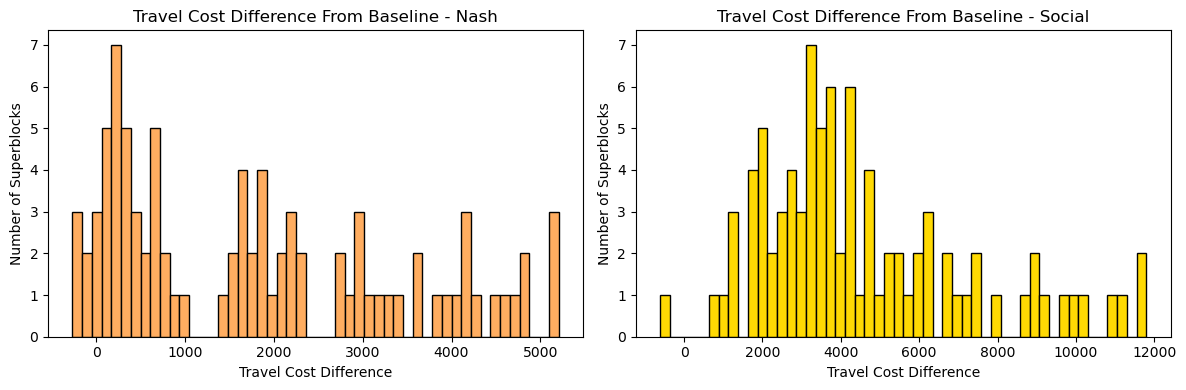

In [264]:
#number of superblocks with lower cost than baseline
 
df_ = df_blocks[df_blocks['cost_diff_nash']<=0].copy()
print("number of superblocks with lower Nash cost",len(df_['cost_diff_nash']))

df_ = df_blocks[df_blocks['cost_diff_social']<=0].copy()
print("number of superblocks with lower social cost",len(df_['cost_diff_social']))

# Updating the provided code to plot histograms side by side
plt.figure(figsize=(12, 4)) # Adjusted overall figure size to accommodate both plots side by side

# Plot for df_nash
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.hist(df_nash['cost_diff'], bins=50, color='#FFAD60', edgecolor='black')
plt.title('Travel Cost Difference From Baseline - Nash')
plt.xlabel('Travel Cost Difference')
plt.ylabel('Number of Superblocks')

# Plot for df_social
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.hist(df_social['cost_diff'], bins=50, color='#FFDA03', edgecolor='black')
plt.title('Travel Cost Difference From Baseline - Social')
plt.xlabel('Travel Cost Difference')
plt.ylabel('Number of Superblocks')

name = 'travel_cost'
plt.savefig('/home/clarice/Documents/VSCode/Term2_Networks/final_project/'+name+'.jpeg')

plt.tight_layout() # Adjust layouts so they do not overlap
plt.show()


3. Produce assessment on total travel time by simulation Nash flow and SO flow

number of superblocks with lower Nash time 87
number of superblocks with lower social time 87


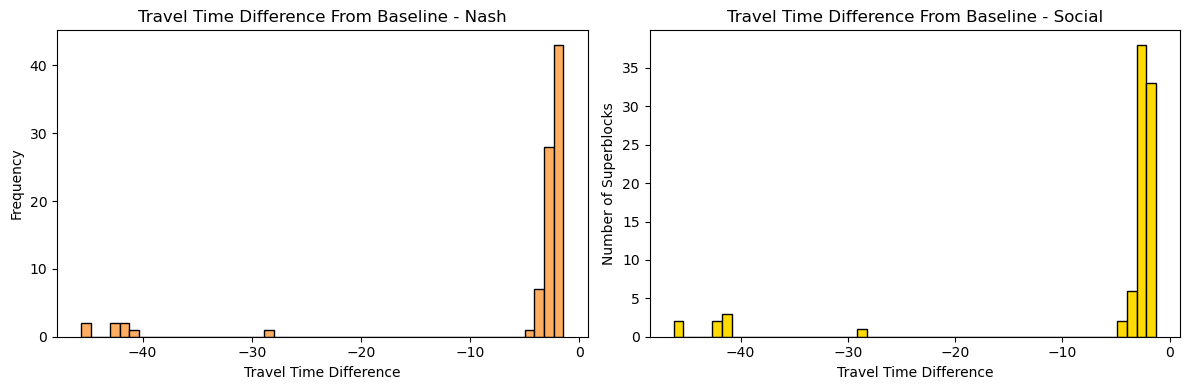

In [265]:
df_ = df_blocks[df_blocks['time_diff_nash']<=0].copy()
print("number of superblocks with lower Nash time",len(df_['time_diff_nash']))

df_ = df_blocks[df_blocks['time_diff_nash']<=0].copy()
print("number of superblocks with lower social time",len(df_['time_diff_nash']))

# Updating the provided code to plot histograms side by side
plt.figure(figsize=(12, 4)) # Adjusted overall figure size to accommodate both plots side by side

# Plot for df_nash
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.hist(df_nash['time_diff'], bins=50, color='#FFAD60', edgecolor='black')
plt.title('Travel Time Difference From Baseline - Nash')
plt.xlabel('Travel Time Difference')
plt.ylabel('Frequency')

# Plot for df_social
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.hist(df_social['time_diff'], bins=50, color='#FFDA03', edgecolor='black')
plt.title('Travel Time Difference From Baseline - Social')
plt.xlabel('Travel Time Difference')
plt.ylabel('Number of Superblocks')

name = 'travel_time'
plt.savefig('/home/clarice/Documents/VSCode/Term2_Networks/final_project/'+name+'.jpeg')


plt.tight_layout() # Adjust layouts so they do not overlap
plt.show()


4. Evaluate PoA against total time differential

number of superblocks with lower poa 84


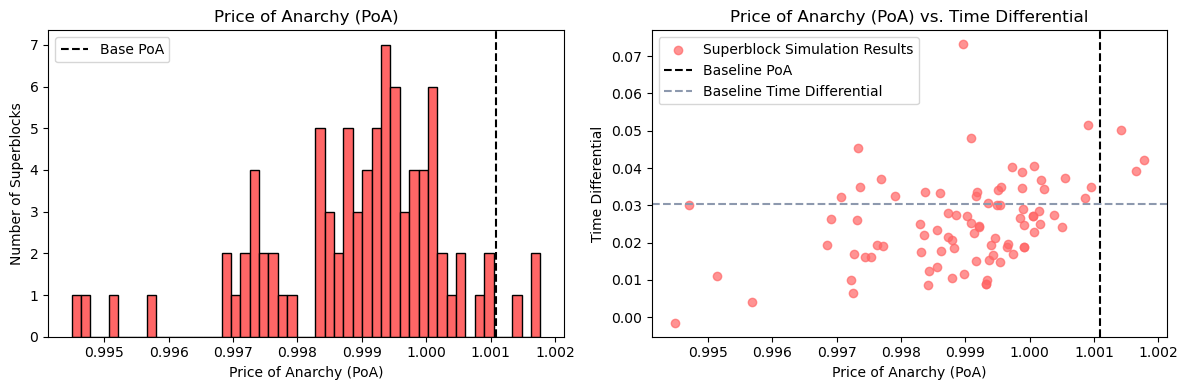

In [269]:
# Assuming df_blocks and df_base are properly defined, and the 'cost_change_per' column exists in df_blocks
# Here's how you could put the two graphs side by side:
df_ = df_blocks[df_blocks['poa_diff']<=0].copy()
print("number of superblocks with lower poa",len(df_['time_diff_nash']))


# Set up the figure and axes for a 1x2 subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot 1: Histogram of Price of Anarchy
axes[0].hist(df_blocks['poa'], bins=50, color='#ff6666', edgecolor='black')
axes[0].axvline(x=df_base.loc[0, 'poa'], color='k', linestyle='--', label='Base PoA')
axes[0].set_title('Price of Anarchy (PoA)')
axes[0].set_xlabel('Price of Anarchy (PoA)')
axes[0].set_ylabel('Number of Superblocks')
axes[0].legend()

# Plot 2: Scatter Plot of PoA vs. Cost Differential
axes[1].scatter(df_blocks['poa'], df_blocks['travel_change_per'], alpha=0.7, label='Superblock Simulation Results', color='#ff6666')
axes[1].axvline(x=df_base.loc[0, 'poa'], color='k', linestyle='--', label='Baseline PoA')
axes[1].axhline(y=df_base.loc[0, 'travel_change_per'], color='#8D99AE', linestyle='--', label='Baseline Time Differential')
axes[1].set_title('Price of Anarchy (PoA) vs. Time Differential')
axes[1].set_xlabel('Price of Anarchy (PoA)')
axes[1].set_ylabel('Time Differential')
axes[1].legend()

name = 'poa_time_diff'
plt.savefig('/home/clarice/Documents/VSCode/Term2_Networks/final_project/'+name+'.jpeg')

plt.tight_layout()
plt.show()


5. Investigate best and worst Superblock placement on Barcelona network

In [270]:
#take the top 5 superblocks with the highest PoA and map them all at the same time
#take the worst 5 superblocks with the lowest PoA and map them all at the same time

list_best_blocks_iter = []

df_blocks.sort_values(by = ['poa'], inplace = True)
df_blocks_best = df_blocks.copy().reset_index(drop = True).loc[0:4,]
list_best_blocks_iter = list(df_blocks_best['block_iter'])

list_worst_blocks_iter = []

df_blocks.sort_values(by = ['poa'], ascending = [False], inplace = True)
df_blocks_worst = df_blocks.copy().reset_index(drop = True).loc[0:4,]
list_worst_blocks_iter = list(df_blocks_worst['block_iter'])

print("best",list_best_blocks_iter)
print("worst",list_worst_blocks_iter)

best [22, 65, 86, 40, 19]
worst [20, 38, 1, 29, 71]


Barcelona with the top 5 superblocks


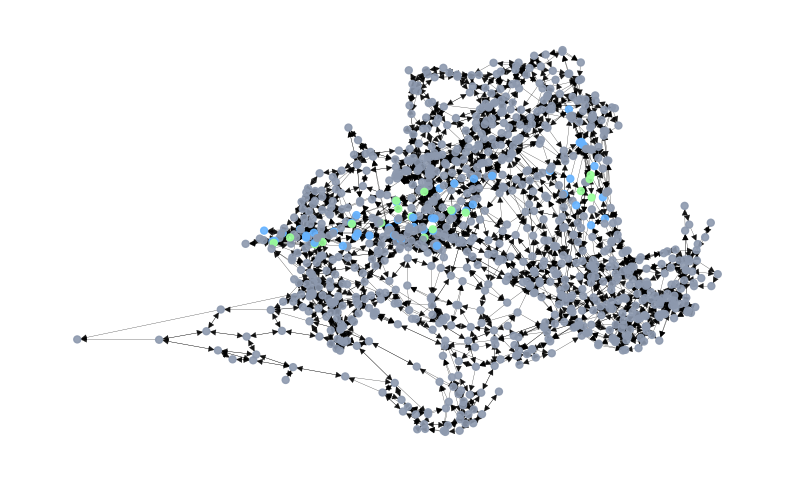

In [271]:
print("Barcelona with the top 5 superblocks")

list_best_center = []
list_best_perimeter = []

for iter_ in dict_superblocks.keys():
    if iter_ in list_best_blocks_iter:
        for node in dict_superblocks[iter_][0]:
            list_best_center.append(node)
        for node in dict_superblocks[iter_][2]:
            list_best_perimeter.append(node)

list_best_center = list(set(list_best_center))
list_best_perimeter = list(set(list_best_perimeter))

list_rmv = []
for i, node in enumerate(list_best_perimeter):
    if node in list_best_center:
        list_rmv.append(i)
list_rmv.sort(reverse = True)
for i in list_rmv:
    del list_best_perimeter[i]

graph_w_superblock(graph, list_best_center, list_best_perimeter, 40, 'barcelona_best')

Barcelona with the worst 5 superblocks


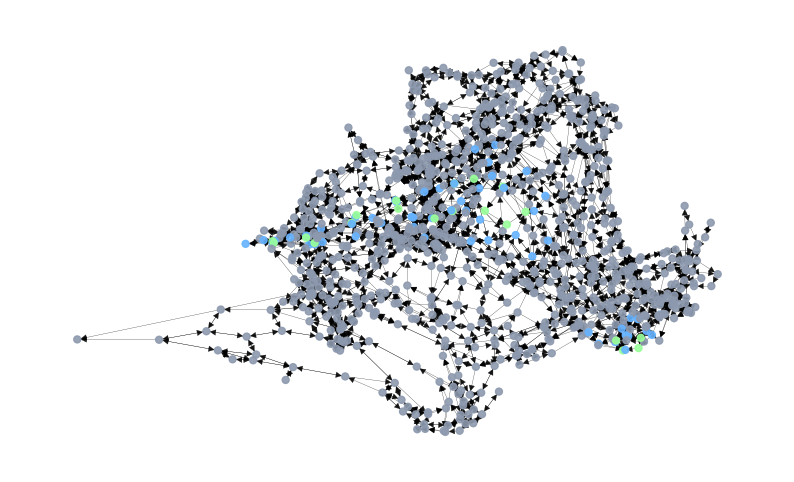

In [272]:
print("Barcelona with the worst 5 superblocks")

list_worst_center = []
list_worst_perimeter = []

for iter_ in dict_superblocks.keys():
    if iter_ in list_worst_blocks_iter:
        for node in dict_superblocks[iter_][0]:
            list_worst_center.append(node)
        for node in dict_superblocks[iter_][2]:
            list_worst_perimeter.append(node)

list_worst_center = list(set(list_worst_center))
list_worst_perimeter = list(set(list_worst_perimeter))

list_rmv = []
for i, node in enumerate(list_worst_perimeter):
    if node in list_worst_center:
        list_rmv.append(i)
list_rmv.sort(reverse = True)
for i in list_rmv:
    del list_worst_perimeter[i]


graph_w_superblock(graph, list_worst_center, list_worst_perimeter, 40, 'barcelona_worst')